In [1]:
import sys
sys.path.append('../python_packages_static/')
import os
import zipfile
import shutil
import pandas as pd
import numpy as np
import rasterio
from pyproj import CRS
from affine import Affine
from rasterio.warp import calculate_default_transform, reproject, Resampling
import matplotlib.pyplot as plt
import re

## Now that the `modpath_run_data` subdirectory is setup with the necessary files, we run one modpath simulation for each of the 358 parameter realizations contained in `modpath_par_ens.csv`. In the papers, this step was referred to as the MODPATH Monte Carlo analysis. 

NOTE: Instructions to run the MODPATH Monte Carlo analysis (completed between workflow notebooks 4.1 and 4.2) are not included here. Notebooks (4.0, 4.1 & 4.2) can only be run with supplied results from `output/modpath`. Users can reproduce this step by running MODPATH once for each MODPATH zone (NE, W, and SE) and parameter realization in `modpath_par_ens.csv` (generated in workflow notebook 3.2_postproc_iES-LT_noise.ipynb). In the papers, this was accomplished using the [HTCondor](https://research.cs.wisc.edu/htcondor/) run manager.

### This notebooks uses the supplied results from the paper. These results are contained in zip files in the `output/modpath` subdirectory. 

In [2]:
mc_path = '../output/modpath_mc/'

### get list of priority wells, and locations

In [3]:
wells_df = pd.read_csv('../processed_data/2009-2016_ave_pumping.csv')
wells_df = wells_df.loc[wells_df.WellType == 'Priority']
priority_wells = wells_df.ID_Well.tolist()
priority_wells

['SV_193', 'SV_227', 'U__55', 'U_917', 'U___7', 'U___8', 'SV_407', 'SV_487']

In [4]:
well_dat_df = pd.read_csv('../neversink_mf6/wel_000.dat', delim_whitespace=True)
well_dat_df = well_dat_df.loc[well_dat_df.boundname.isin(priority_wells)]

well_dat_df['i_zb'] = well_dat_df['i'] - 1
well_dat_df['j_zb'] = well_dat_df['j'] - 1

particle_ys = [y for y in well_dat_df['i_zb']]
particle_xs = [x for x in well_dat_df['j_zb']]

### list pumping scenarios

In [5]:
qrats = ['maxrat', '0.25rat', '0.5rat', '0.75rat', 'maxrange', 'baserat']

# Create rasters from MODPATH MC results

### Probablistic contributing recharge areas to priority wells for each pumping scenario

processing maxrat results...


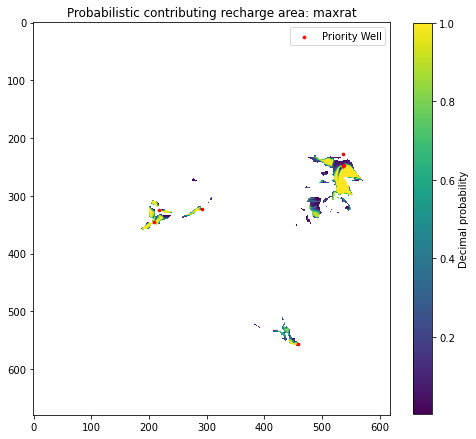

wrote ../output/modpath_mc/mp_mc_maxrat.tif

processing 0.25rat results...


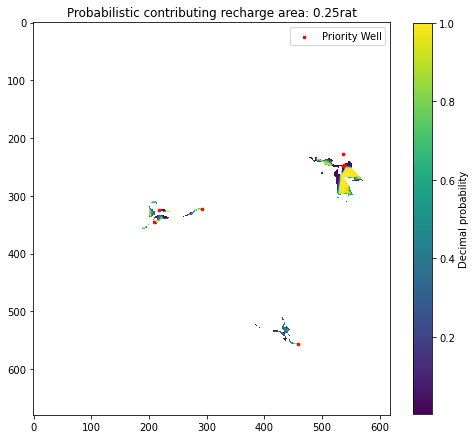

wrote ../output/modpath_mc/mp_mc_0.25rat.tif

processing 0.5rat results...


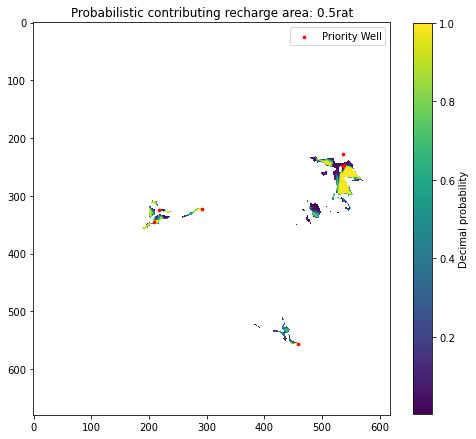

wrote ../output/modpath_mc/mp_mc_0.5rat.tif

processing 0.75rat results...


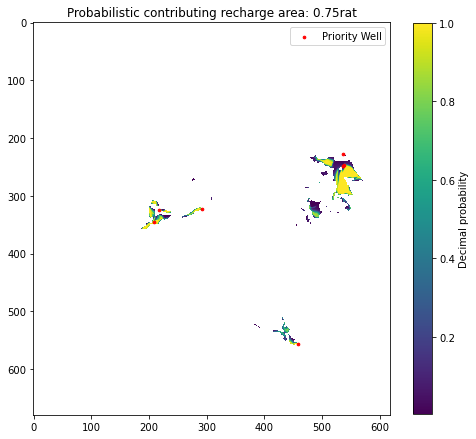

wrote ../output/modpath_mc/mp_mc_0.75rat.tif

processing maxrange results...


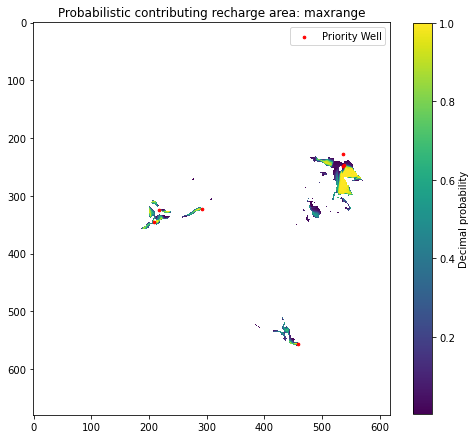

wrote ../output/modpath_mc/mp_mc_maxrange.tif

processing baserat results...


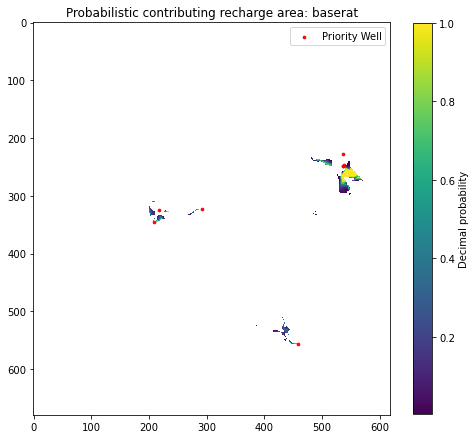

wrote ../output/modpath_mc/mp_mc_baserat.tif



In [6]:
for qrat in qrats:
    print(f'processing {qrat} results...')
    with zipfile.ZipFile(os.path.join(mc_path, f'{qrat}.zip'),"r") as zip_ref:
        zip_ref.extractall(mc_path)

    mp_grid = np.zeros((680, 619)) 
    nonzero_mc_count = 0

    for file in os.listdir(os.path.join(mc_path, qrat)):
        real_arr = np.loadtxt(os.path.join(mc_path, qrat, file))
        if not real_arr.sum == 0:
            mp_grid += real_arr
            nonzero_mc_count += 1

    mp_grid /= nonzero_mc_count   

    #  plot results with priority wells
    grid_for_plotting = mp_grid.copy()
    grid_for_plotting[grid_for_plotting == 0.]=np.nan

    fig, ax = plt.subplots(figsize=(8,8))
    im = ax.imshow(grid_for_plotting)
    fig.colorbar(im, label='Decimal probability', shrink=0.9) 
    ax.scatter(particle_xs, particle_ys, c='r', label='Priority Well', s=7)
    ax.set_title(f'Probabilistic contributing recharge area: {qrat}')
    ax.legend()
    plt.show()

    #  export results as geotiff
    out_grid = mp_grid.copy()
    out_grid[out_grid == 0.] = -9999.

    outfile = f'mp_mc_{qrat}.tif'
    raster_outpath = os.path.join(mc_path, outfile)

    dataset = rasterio.open(
        raster_outpath, 
        'w', 
        driver='GTiff',
        height = out_grid.shape[0], 
        width = out_grid.shape[1],
        count=1,
        nodata = -9999.0,
        dtype=str(out_grid.dtype),
        crs = CRS.from_epsg(5070),
        transform=Affine(50.0, 0.0, 1742955.0,
                         0.0, -50.0, 2292285.0),
    )

    dataset.write(out_grid, 1)
    dataset.close()
    print(f'wrote {raster_outpath}\n')

    # cleanup unzipped directory
    shutil.rmtree(os.path.join(mc_path, qrat))